# 计算点度中心性因子

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import feather
from tqdm.notebook import tqdm
import os

## 读入数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20240630.feather')
price_1d = price_1d[(price_1d['date'] >= '2019-01-01') & (price_1d['date'] <= '2024-12-31')]
prc = price_1d.sort_values(['date', 'issue']).set_index('date')

In [3]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start=trade_date[0], end=trade_date[-1]+pd.DateOffset(months=1), freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
calc_start_date = np.array([], dtype=np.datetime64)

for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
    if (len(trade_date_before) > 120):
        csd = trade_date_before[-120]
    else:
        csd = trade_date_before[0]
    calc_start_date = np.append(calc_start_date, csd)

adj_date = adj_date[7:]
calc_start_date = calc_start_date[7:]
adj_date[-1] = pd.Timestamp('2024-06-28')

### 读入公司列表

In [4]:
issues = feather.read_dataframe('../data/issues.feather')

### 读入测试数据

In [5]:
corr_num = feather.read_dataframe('../data/corr/corr_num_20190830.feather')

## 计算点度中心性

In [6]:
def N_connect_calc(connect_method, dirname, *args, **kwargs):
    remove_num = []
    remove_size = []
    df_num = None
    df_size = None
    os.makedirs(dirname, exist_ok=True)
    
    for ad in tqdm(adj_date):
        ad_str = ad.strftime('%Y%m%d')
        issues_date = issues.loc[ad, 'issue'].to_numpy()
        
        corr_num = feather.read_dataframe(f'../data/corr/corr_num_{ad_str}.feather')
        nc_num = connect_method(corr_num, *args, **kwargs)
        r_num = (nc_num == 0).sum()
        remove_num.append(r_num / len(issues_date))
        df_num_ad = pd.DataFrame({'issue': issues_date, 'date': ad, 'N_connect': nc_num})
        df_num = pd.concat([df_num, df_num_ad])
        
        corr_size = feather.read_dataframe(f'../data/corr/corr_size_{ad_str}.feather')
        nc_size = connect_method(corr_size, *args, **kwargs)
        r_size = (nc_size == 0).sum()
        remove_size.append(r_size / len(issues_date))
        df_size_ad = pd.DataFrame({'issue': issues_date, 'date': ad, 'N_connect': nc_size})
        df_size = pd.concat([df_size, df_size_ad])
    
    feather.write_dataframe(df_num, dirname + '/N_connect_num.feather')
    feather.write_dataframe(df_size, dirname + '/N_connect_size.feather')
    
    plt.plot(adj_date, remove_num, label='num')
    plt.plot(adj_date, remove_size, label='size')
    plt.legend()
    plt.show()

## 方法0: 稀疏化处理后取单向连接

In [7]:
def connect_0(corr, axis=1):
    '''
    axis=1 表示统计焦点股票的关联股票个数
    axis=0 表示统计与该股票关联的焦点股票个数
    '''
    w = corr.values.copy()
    np.fill_diagonal(w, 0)
    thresh = np.median(w[w > 0])
    w[w <= thresh] = 0
    a = (w > 0).astype(int)
    N_connect = a.sum(axis=axis)
    return N_connect

  0%|          | 0/59 [00:00<?, ?it/s]

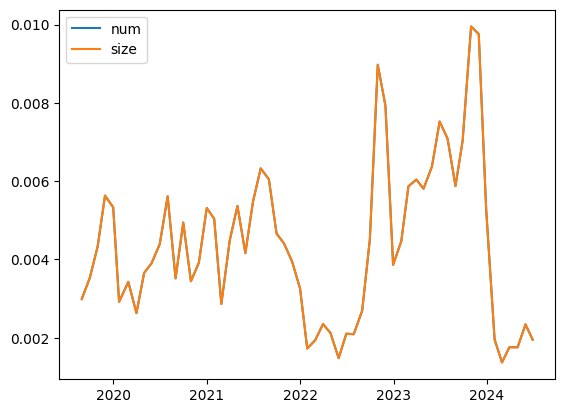

In [8]:
N_connect_calc(connect_0, '../data/N_connect_0_1/', axis=1)

  0%|          | 0/59 [00:00<?, ?it/s]

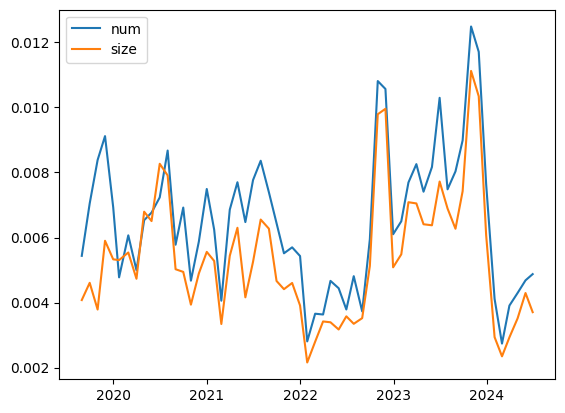

In [9]:
N_connect_calc(connect_0, '../data/N_connect_0_0/', axis=0)

## 方法1: 稀疏化处理后建立双向连接

In [10]:
def connect_1(corr, method='both'):
    w = corr.values.copy()
    np.fill_diagonal(w, 0)
    thresh = np.median(w[w > 0])
    w[w <= thresh] = 0
    a = (w > 0).astype(int)
    if method == 'any':
        a = np.maximum(a, a.T) # 单向连接就可以
    elif method == 'both':
        a = np.minimum(a, a.T) # 需要双向都有连接
    N_connect = a.sum(axis=1)
    return N_connect

  0%|          | 0/59 [00:00<?, ?it/s]

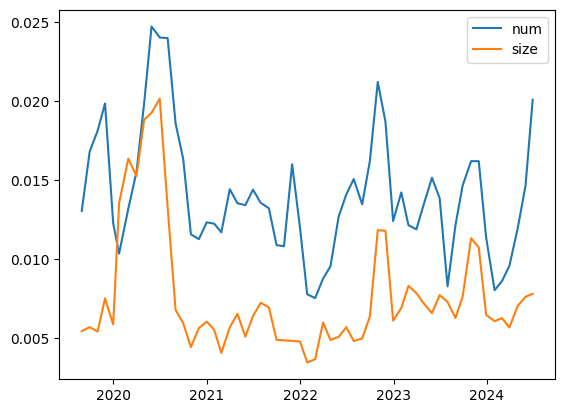

In [11]:
N_connect_calc(connect_1, '../data/N_connect_1_both/', method='both')

  0%|          | 0/59 [00:00<?, ?it/s]

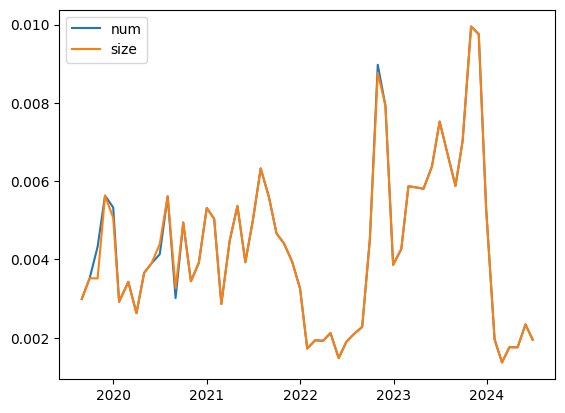

In [12]:
N_connect_calc(connect_1, '../data/N_connect_1_any/', method='any')

## 方法2: 先对双向相关度取平均值再稀疏化处理